In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
#Openning the dataset and setting date as index
df = pd.read_csv("/content/drive/MyDrive/Electric_Production.csv")
df = df.set_index("DATE")
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')
# df = df.groupby(pd.Grouper(freq='m')).mean()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


,Value
DATE,
1985-01-01,72.5052
1985-01-02,70.6720
1985-01-03,62.4502
1985-01-04,57.4714
1985-01-05,55.3151


Number of measurements: 397


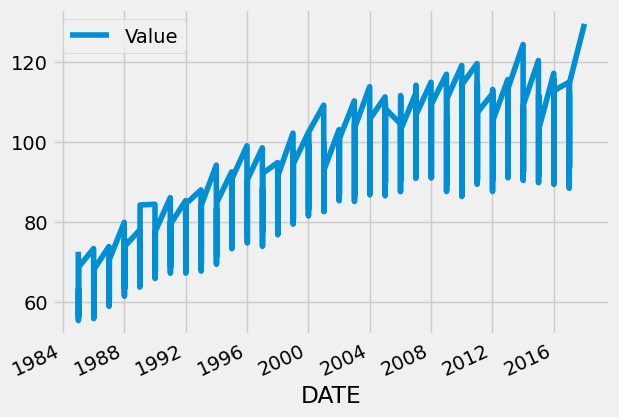

In [ ]:
import matplotlib.pyplot as plt

#Ploting temperature in Celsius degrees
print("Number of measurements: "+str(len(df['Value'])))
df.plot(y='Value', rot=25);

In [ ]:
dftm = df['Value']
print(dftm)

DATE
1985-01-01     72.5052
1985-01-02     70.6720
1985-01-03     62.4502
1985-01-04     57.4714
1985-01-05     55.3151
                ...   
2017-01-09     98.6154
2017-01-10     93.6137
2017-01-11     97.3359
2017-01-12    114.7212
2018-01-01    129.4048
Name: Value, Length: 397, dtype: float64


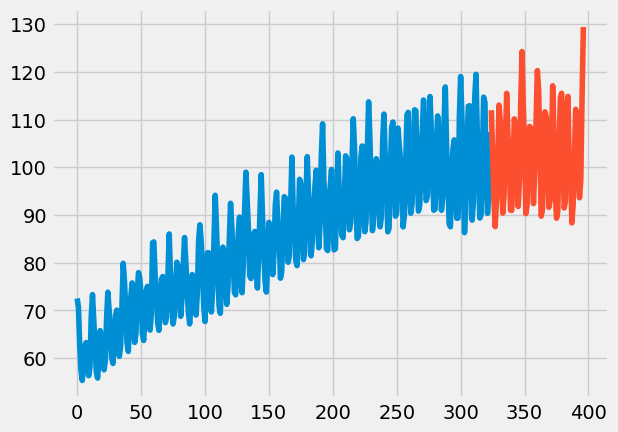

In [ ]:
import numpy as np

# Spliting the last 2 years for test
# train-test ratio is 4:1

train = dftm[:12*27].values
plt.plot(np.arange(len(train)),train)
train = train.reshape((len(train), 1))

test = dftm[12*27:].values
plt.plot(np.arange(len(train), len(train)+len(test)),test)
test = test.reshape((len(test), 1))
#plt.plot(np.arange(len(df3d)), df3d)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 12
generator = TimeseriesGenerator(train,train,length=length, batch_size=1)
validation_generator = TimeseriesGenerator(test,test,length=length, batch_size=1)

In [ ]:
print(train[:length+1])

[[72.5052]
 [70.672 ]
 [62.4502]
 [57.4714]
 [55.3151]
 [58.0904]
 [62.6202]
 [63.2485]
 [60.5846]
 [56.3154]
 [58.0005]
 [68.7145]
 [73.3057]]


In [ ]:
i=0
for x,y in generator:
    print(x)
    print(y)
    i = i + 1
    if i == 2:
        break

[[[72.5052]
  [70.672 ]
  [62.4502]
  [57.4714]
  [55.3151]
  [58.0904]
  [62.6202]
  [63.2485]
  [60.5846]
  [56.3154]
  [58.0005]
  [68.7145]]]
[[73.3057]]
[[[70.672 ]
  [62.4502]
  [57.4714]
  [55.3151]
  [58.0904]
  [62.6202]
  [63.2485]
  [60.5846]
  [56.3154]
  [58.0005]
  [68.7145]
  [73.3057]]]
[[67.9869]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(GRU(20, activation='relu', return_sequences=True, input_shape=(length,1))) # input sequence length is 12 here
model.add(GRU(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mape') # Adam Optimizer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 20)            1380      
                                                                 
 gru_1 (GRU)                 (None, 10)                960       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 2351 (9.18 KB)
Trainable params: 2351 (9.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
epochs = 100
early_stop = EarlyStopping(monitor='val_loss',patience=10) # we've taken patience parameter as 10
ckpt = ModelCheckpoint('model6.hdf5', save_best_only=True, monitor='val_loss', verbose=1)
history = model.fit(
    generator,
    steps_per_epoch=len(generator),
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stop, ckpt]
    )

Epoch 1/100
312/312 [==============================] - ETA: 0s - loss: 19.8850
Epoch 1: val_loss improved from inf to 5.14855, saving model to model6.hdf5
312/312 [==============================] - 7s 14ms/step - loss: 19.8850 - val_loss: 5.1486
Epoch 2/100
  5/312 [..............................] - ETA: 4s - loss: 4.8082 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


312/312 [==============================] - ETA: 0s - loss: 6.1839
Epoch 2: val_loss did not improve from 5.14855
312/312 [==============================] - 5s 17ms/step - loss: 6.1839 - val_loss: 7.8768
Epoch 3/100
311/312 [============================>.] - ETA: 0s - loss: 5.1649
Epoch 3: val_loss did not improve from 5.14855
312/312 [==============================] - 3s 11ms/step - loss: 5.1800 - val_loss: 5.1993
Epoch 4/100
310/312 [============================>.] - ETA: 0s - loss: 4.5858
Epoch 4: val_loss did not improve from 5.14855
312/312 [==============================] - 4s 11ms/step - loss: 4.5712 - val_loss: 6.4809
Epoch 5/100
310/312 [============================>.] - ETA: 0s - loss: 4.1063
Epoch 5: val_loss improved from 5.14855 to 5.06425, saving model to model6.hdf5
312/312 [==============================] - 5s 15ms/step - loss: 4.1104 - val_loss: 5.0643
Epoch 6/100
310/312 [============================>.] - ETA: 0s - loss: 3.9155
Epoch 6: val_loss did not improve from 5.

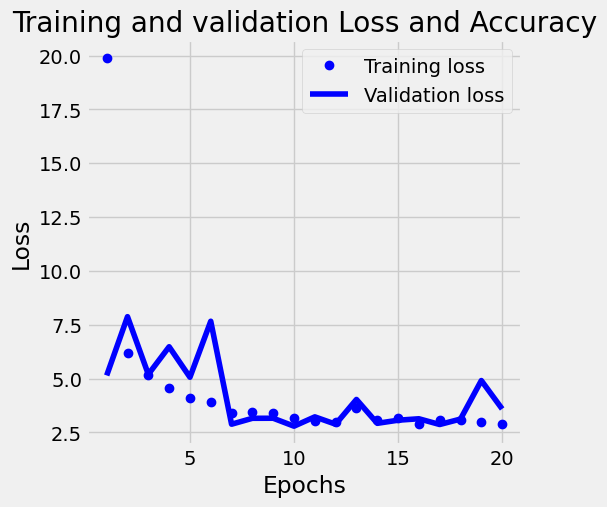

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(5,5))
#plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Load the best model
model.load_weights("model6.hdf5")

# Predicting some days ahead.
test_predictions = []
first_eval_batch = train[-length:]
current_batch = first_eval_batch.reshape((1, length, 1))
for i in range(len(test)):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred)
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
#prediction = scaler.inverse_transform(test_predictions)

1/1 [==============================] - 0s 25ms/step


Text(0, 0.5, 'Consumption')

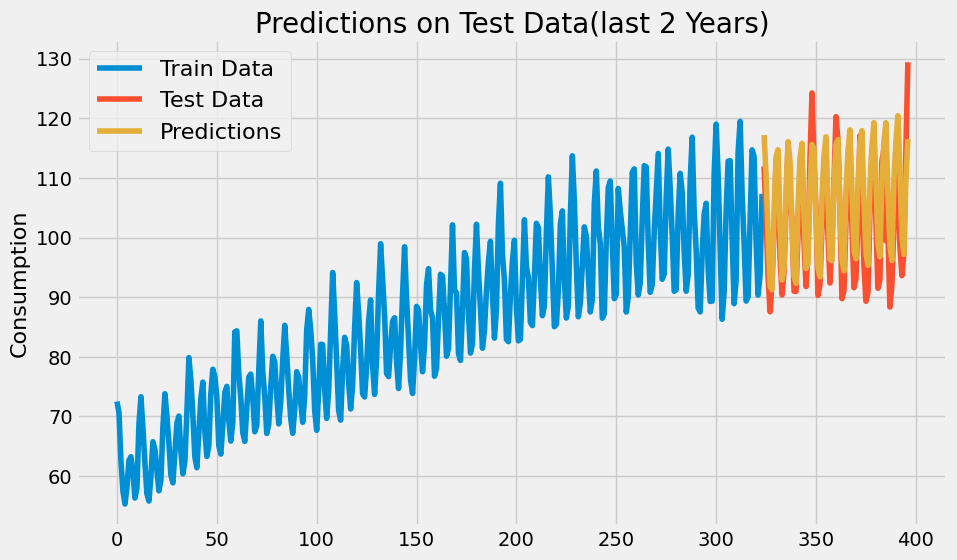

In [ ]:
# Comparing test data and predictions
plt.figure(figsize=(10,6))

plt.plot(np.arange(len(train)), train)
plt.plot(np.arange(len(train),len(train)+len(test)),test)
plt.plot(np.arange(len(train),len(train)+len(test)),test_predictions)

plt.legend(('Train Data', 'Test Data', 'Predictions'), fontsize=16)
plt.title('Predictions on Test Data(last 2 Years)', fontsize=20)
plt.ylabel('Consumption', fontsize=16)

In [ ]:
new_list=[]

for i in range(len(test_predictions)):
  new_list.append([dftm[12*27+i],test_predictions[i]])
print(new_list)

[[111.9646, array([117.18381], dtype=float32)], [103.3679, array([110.45662], dtype=float32)], [93.5772, array([100.45778], dtype=float32)], [87.5566, array([91.77568], dtype=float32)], [92.7603, array([91.24056], dtype=float32)], [101.14, array([104.05304], dtype=float32)], [113.0357, array([113.521126], dtype=float32)], [109.8601, array([114.73581], dtype=float32)], [96.7431, array([101.712234], dtype=float32)], [90.3805, array([92.89895], dtype=float32)], [94.3417, array([94.92052], dtype=float32)], [105.2722, array([107.62245], dtype=float32)], [115.501, array([116.08822], dtype=float32)], [106.734, array([112.836075], dtype=float32)], [102.9948, array([101.71319], dtype=float32)], [91.0092, array([93.53652], dtype=float32)], [90.9634, array([92.329926], dtype=float32)], [100.6957, array([105.32137], dtype=float32)], [110.148, array([113.35636], dtype=float32)], [108.1756, array([115.789566], dtype=float32)], [99.2809, array([103.8488], dtype=float32)], [91.7871, array([94.81062], 

In [ ]:
# Calculating the mean squared error
loss = np.mean(np.square(test[:,0] - np.array(test_predictions)[:,0]), axis=-1)
print("mse: "+str(loss))

mse: 35.97630821976634


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE
rmse= round(sqrt(mean_squared_error(test, test_predictions)),4)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate MAE
mae = round(mean_absolute_error(test, test_predictions),4)
print("Mean Absolute Error (MAE):", mae)

#Calculate MAPE
test_np= np.array(test)
predictions_np= np.array(test_predictions)
mape= round(np.mean(abs((predictions_np - test_np)/test_np)),4)
print(f'Mean Absolute Percent Error(MAPE): {mape*100}%')

#Calculate R2 Score
r2= r2_score(test,test_predictions)
print("R2 Score:",r2)

Root Mean Squared Error (RMSE): 5.998
Mean Absolute Error (MAE): 4.877
Mean Absolute Percent Error(MAPE): 4.8%
R2 Score: 0.61336175869559
